## Introduction:
Effective waste recycling is both economic and environmentally beneficial. It can help in recovering raw resources, preserving energy, mitigating greenhouse gaseous emission, water pollution, reducing new landfills. For that reason, we decide to use deep learning for building a classification system the waste item as either recyclable or not.

## objective

we will train a convolutional neural network to classify an image as either cardboard, glass, metal, paper, plastic, or trash with the fastai library (built on PyTorch). 

## steps

1. Download and extract the images
2. Organize the images into different folders
3. Train the model
4. save the model
5. Make and evaluate test predictions
6. export the model
7. load and test it from real pictures!

In [ ]:
#!pip install Pillow==4.0.0
#pip install PIL
#!pip install image

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [ ]:
from fastai.vision import *

from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
import pickle


## 1. Extract data

In [ ]:
files = zf.ZipFile("/content/drive/MyDrive/Recycle_Classification/dataset-resized.zip",'r')
files.extractall()
files.close()

In [ ]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['trash', 'cardboard', 'paper', 'metal', 'glass', '.DS_Store', 'plastic']

## 2. Organize images into different folders
 split images into train, validation, and test image folders with a 50-25-25 split.

In [ ]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)


/data <br>
&nbsp;&nbsp;&nbsp;&nbsp; /train <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp; /valid <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp;/test <br>

Each image file is just the material name and a number (i.e. cardboard1.jpg)



In [ ]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [ ]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [ ]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


The batch size bs is how many images you'll train at a time.

In [ ]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
trash,trash,trash,trash,trash
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
trash,trash,trash,trash,trash
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [ ]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Here's an example of what the data looks like:

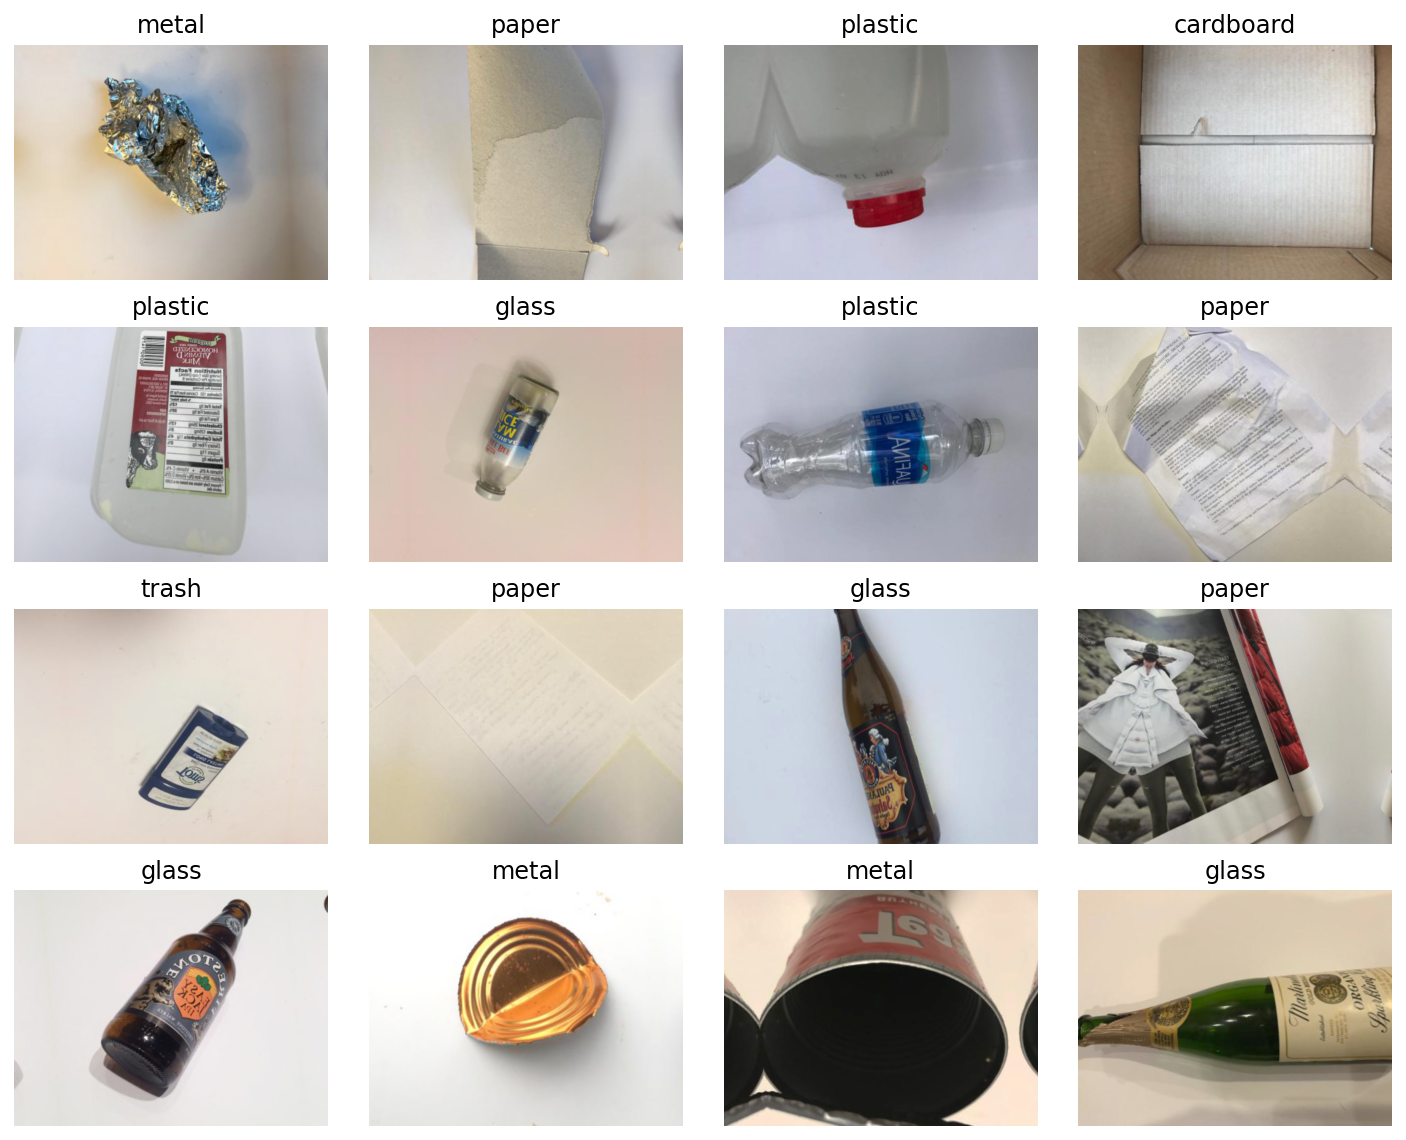

In [ ]:
data.show_batch(rows=4,figsize=(10,8))

## 3. Model training

In [ ]:
learn = cnn_learner(data,models.resnet18,metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 192, 256]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 192, 256]       128        True      
______________________________________________________________________
ReLU                 [64, 192, 256]       0          False     
______________________________________________________________________
MaxPool2d            [64, 96, 128]        0          False     
______________________________________________________________________
Conv2d               [64, 96, 128]        36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 96, 128]        128        True      
______________________________________________________________________
ReLU                 [64, 96, 128]        0          False     
___________________________________________________

### Finding a learning rate

find a learning rate for gradient descent to make sure that neural network converges reasonably quickly without missing the optimal error.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


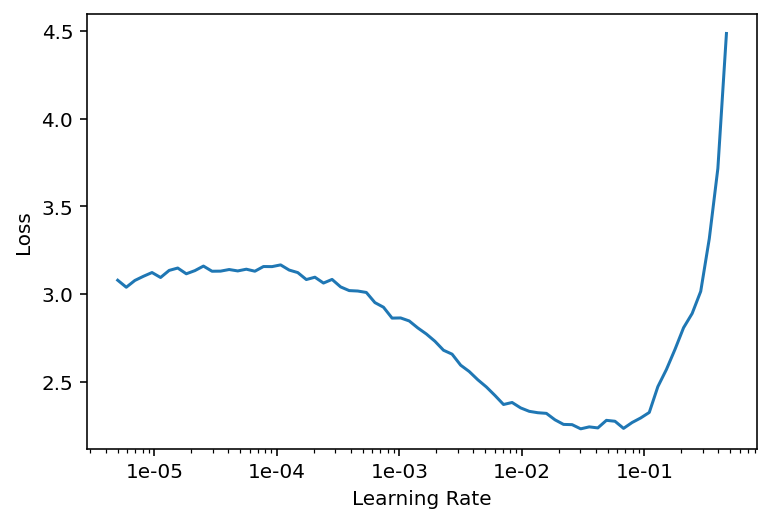

In [ ]:
learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

Min numerical gradient: 6.03E-03
Min loss divided by 10: 3.02E-03


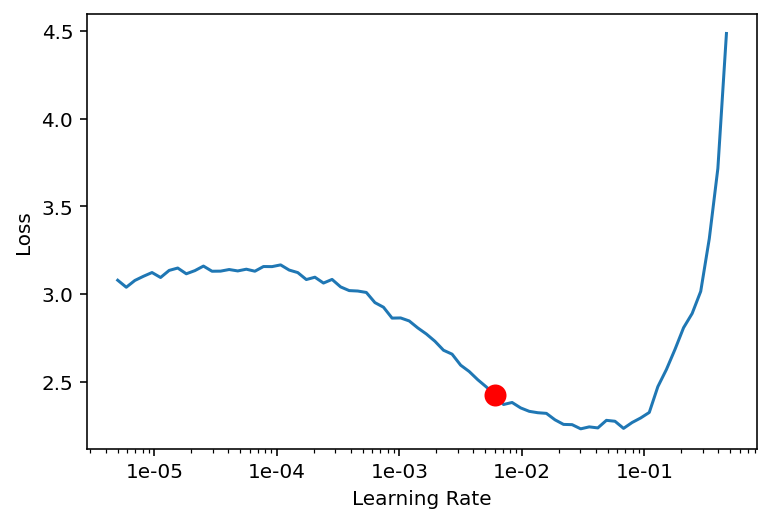

In [ ]:
learn.recorder.plot(suggestion=True)

In [ ]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.0060255958607435805

### Training

In [ ]:
learn.fit_one_cycle(50,min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.638544,0.812616,0.715873,00:41
1,1.191606,0.590284,0.787302,00:40
2,0.883248,0.496125,0.822222,00:40
3,0.774112,0.497617,0.836508,00:41
4,0.744911,0.480184,0.841270,00:41
5,0.641525,0.426797,0.858730,00:41
6,0.647384,0.478498,0.846032,00:42
7,0.668205,0.507246,0.825397,00:41
8,0.693659,0.602851,0.801587,00:41
9,0.760658,0.652498,0.792063,00:41


# 4.save model

In [ ]:
learn.save("/content/drive/MyDrive/Recycle_Classification/modelAfterTrainResNet18") 

### VIsualizing most incorrect images

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

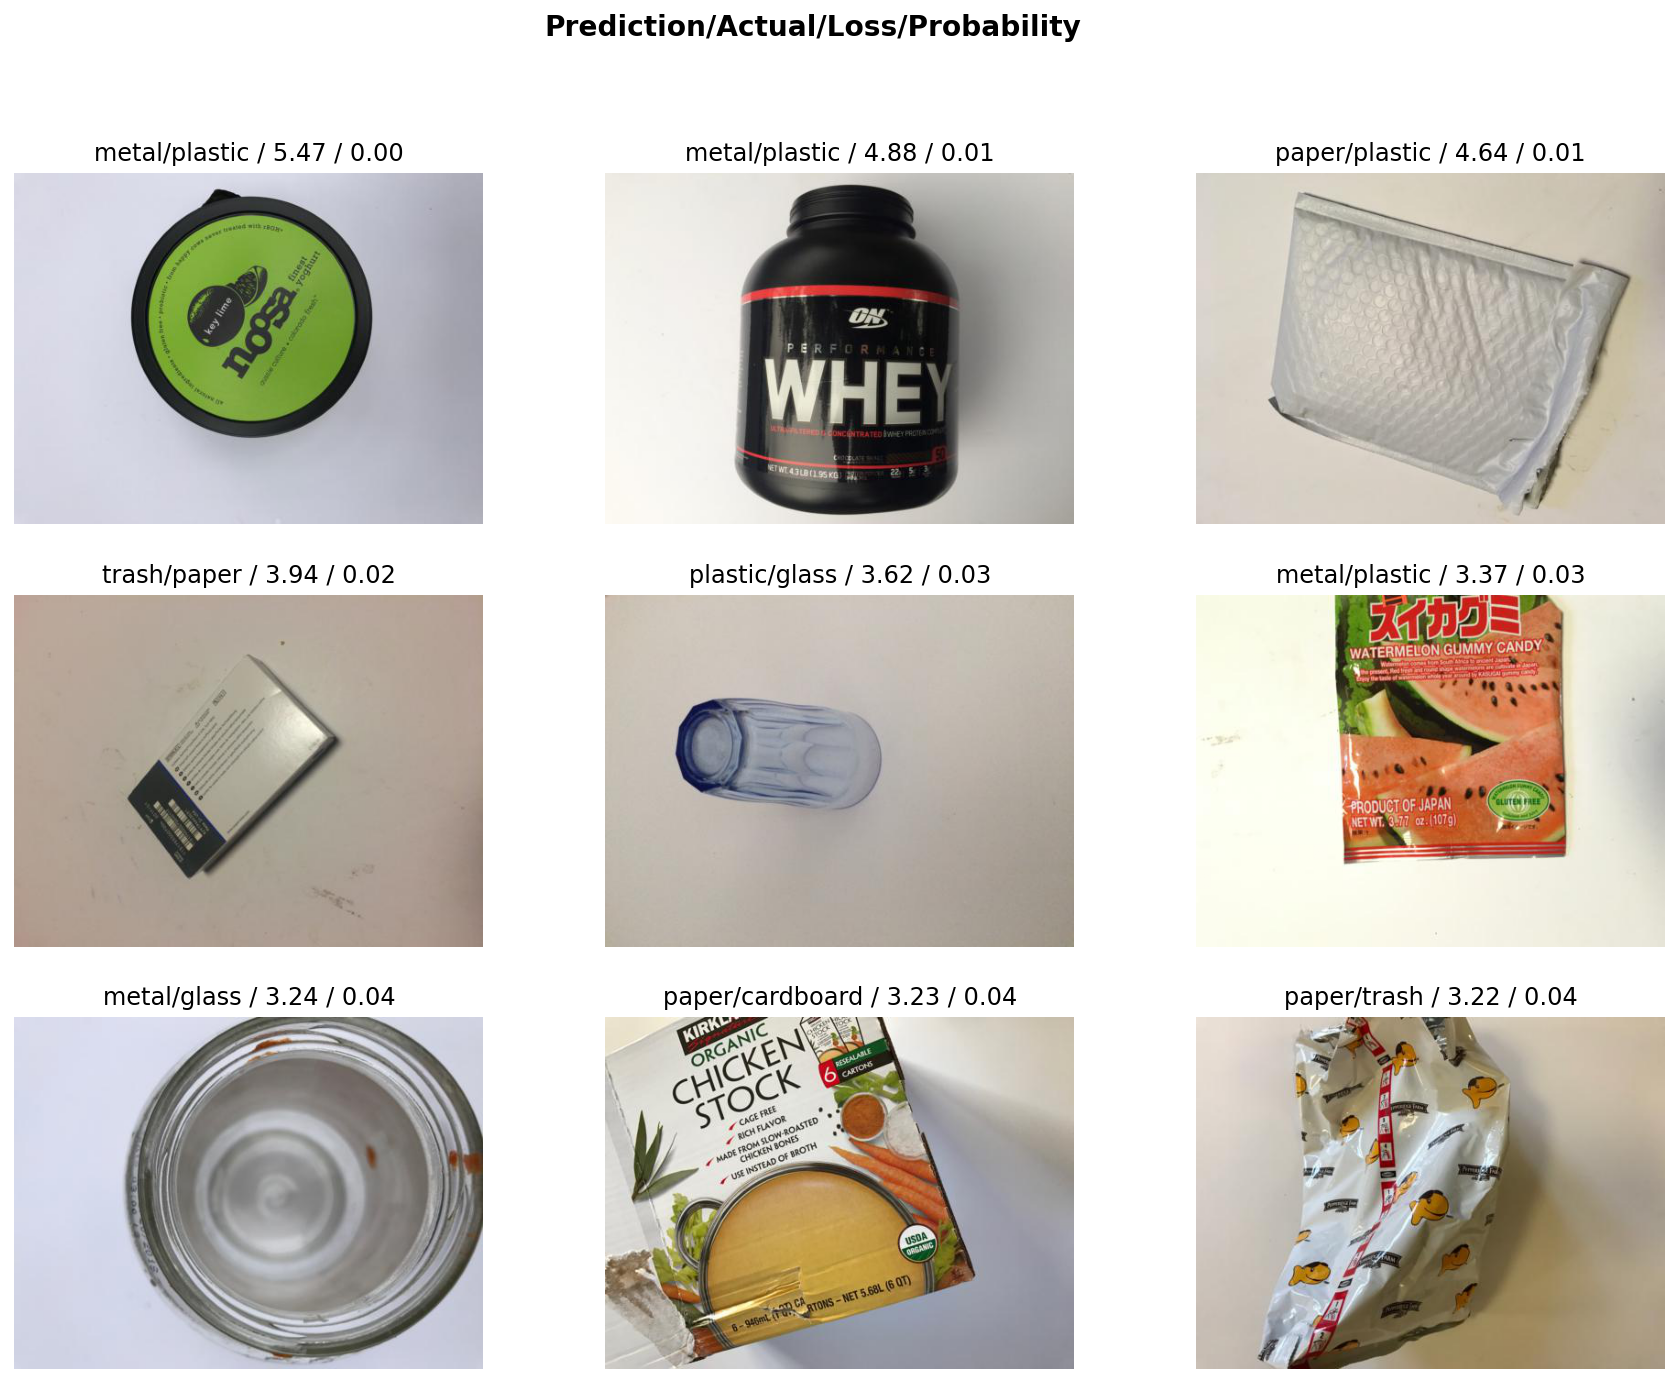

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

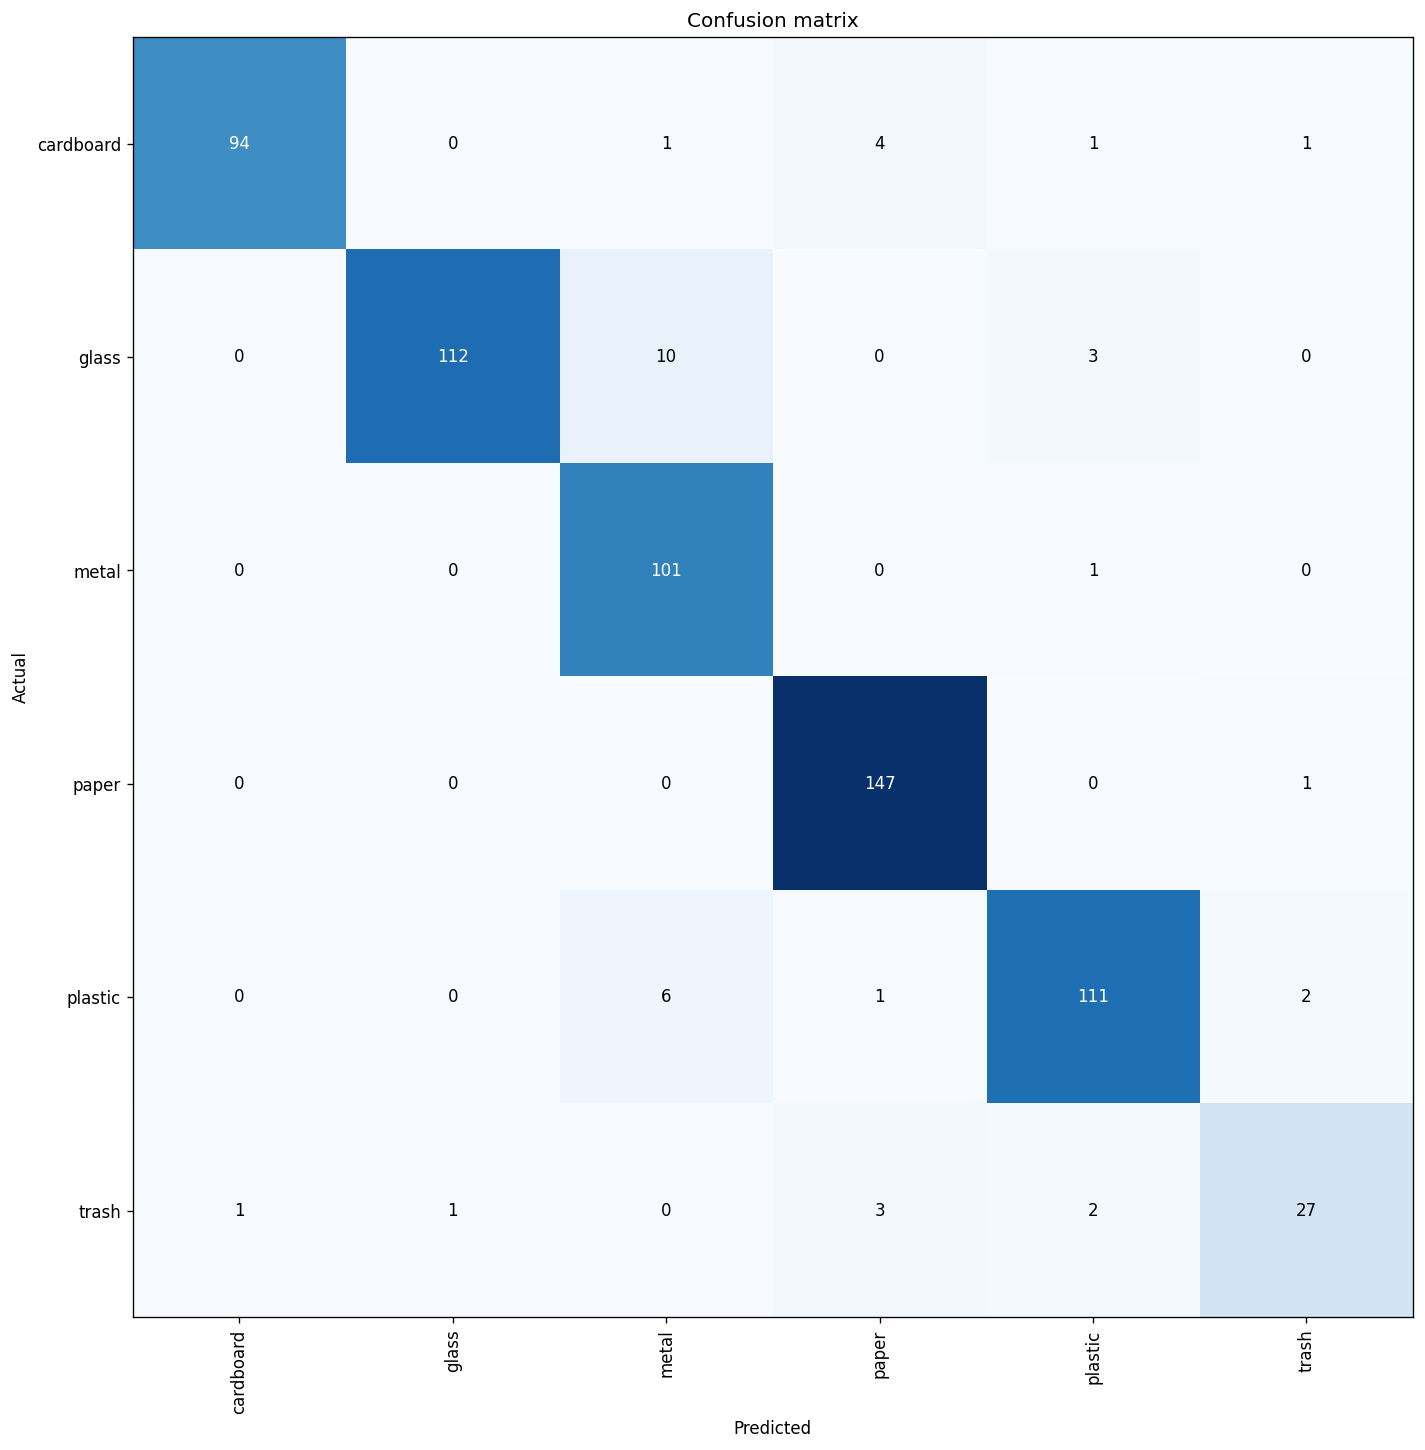

In [ ]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

This model often confused cardboard for paper and confused glass for plastic.

In [ ]:
interp.most_confused(min_val=2)

[('glass', 'metal', 10),
 ('plastic', 'metal', 6),
 ('cardboard', 'paper', 4),
 ('glass', 'plastic', 3),
 ('trash', 'paper', 3),
 ('plastic', 'trash', 2),
 ('trash', 'plastic', 2)]

## 5. Make new predictions on test data


In [ ]:
preds = learn.get_preds(ds_type=DatasetType.Test)

print(preds[0].shape)
preds[0]

In [ ]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

 convert the probabilities in the tensor above to a string with one of the class names.

In [ ]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [ ]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [ ]:
yhat

['paper',
 'metal',
 'metal',
 'paper',
 'glass',
 'cardboard',
 'plastic',
 'plastic',
 'glass',
 'metal',
 'glass',
 'metal',
 'glass',
 'cardboard',
 'plastic',
 'cardboard',
 'paper',
 'plastic',
 'metal',
 'plastic',
 'glass',
 'glass',
 'plastic',
 'paper',
 'metal',
 'plastic',
 'trash',
 'glass',
 'cardboard',
 'paper',
 'glass',
 'cardboard',
 'paper',
 'paper',
 'metal',
 'plastic',
 'paper',
 'paper',
 'cardboard',
 'plastic',
 'paper',
 'glass',
 'plastic',
 'cardboard',
 'cardboard',
 'paper',
 'cardboard',
 'metal',
 'plastic',
 'plastic',
 'paper',
 'trash',
 'paper',
 'cardboard',
 'plastic',
 'paper',
 'cardboard',
 'trash',
 'glass',
 'paper',
 'trash',
 'paper',
 'glass',
 'cardboard',
 'metal',
 'paper',
 'cardboard',
 'glass',
 'plastic',
 'paper',
 'plastic',
 'metal',
 'trash',
 'plastic',
 'trash',
 'paper',
 'glass',
 'metal',
 'paper',
 'paper',
 'paper',
 'cardboard',
 'glass',
 'plastic',
 'paper',
 'plastic',
 'glass',
 'glass',
 'paper',
 'glass',
 'glass'

These are the predicted labels of all the images! Let's check if the first image is actually plastic?.

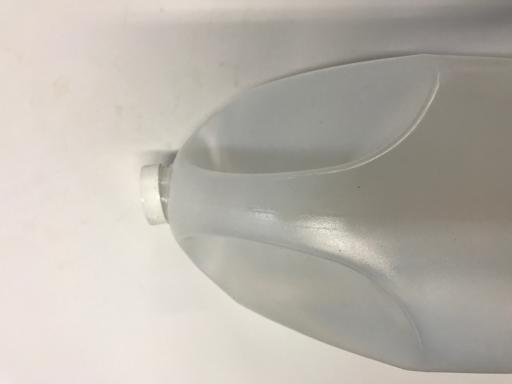

In [ ]:
learn.data.test_ds[0][0]

YES! 


is metal?

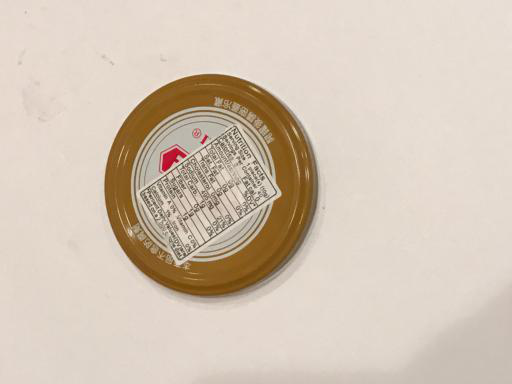

In [ ]:
learn.data.test_ds[2][0]

Yes,it is

Next, get the actual labels from the test dataset.

In [ ]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

A quick check.

In [ ]:
## predicted values
print(yhat[0:10])
## actual values
print(y[0:10])

['paper', 'metal', 'metal', 'paper', 'glass', 'cardboard', 'plastic', 'plastic', 'glass', 'metal']
['plastic', 'metal', 'metal', 'paper', 'glass', 'cardboard', 'plastic', 'plastic', 'trash', 'metal']


It looks the first 10 predictions, 8 of them match up! (check)

How did we end up doing? Again we can use a confusion matrix to find out.

### Test confusion matrix

In [ ]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 93   0   3   5   0   0]
 [  0 110  11   0   5   0]
 [  2   5  94   0   2   0]
 [  0   0   3 144   0   2]
 [  0   3   0   1 116   1]
 [  1   1   2   2   3  26]]


Let's try and make this matrix a little prettier.

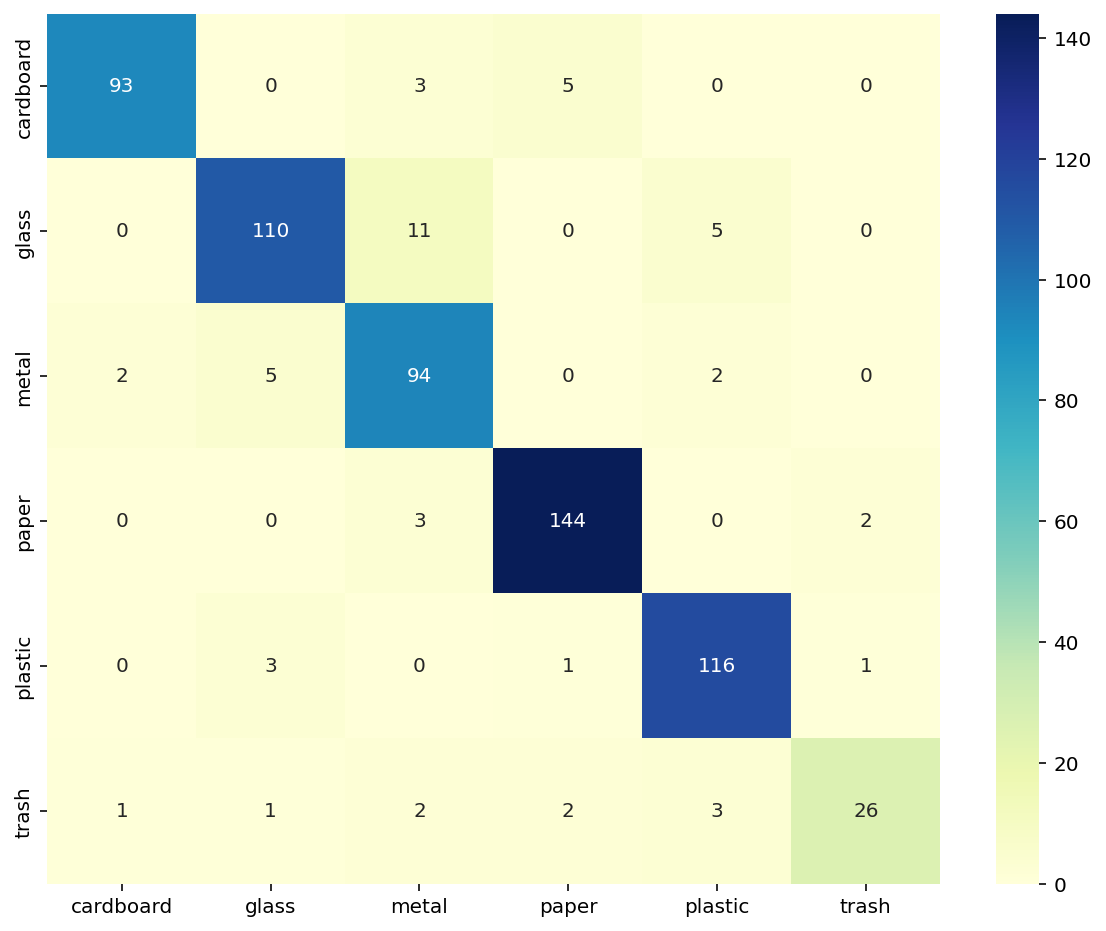

In [ ]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

Again, the model seems to have confused cardboard for paper and confused glass for plastic.

In [ ]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [ ]:
accuracy = correct/sum(sum(cm))
accuracy

0.9181102362204724

In [ ]:
## delete everything when you're done to save space
#shutil.rmtree("data")

#shutil.rmtree('dataset-resized')

## 6.export the model

In [ ]:
learn.export('/content/drive/MyDrive/Recycle_Classification/ModelResNet18.pkl')

## 7.upload the model and test it 

In [ ]:
learnModel = load_learner('/content/drive/MyDrive/Recycle_Classification/','ModelResNet18.pkl')

In [ ]:
#learnModel

In [ ]:

import cv2
from fastai.vision import *
img_cv2 = cv2.imread('/content/drive/MyDrive/Recycle_Classification/TestImagesFromGoogle/paper.jpg')
img_fastai = Image(pil2tensor(img_cv2,np.float32).div_(255))
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(type(img_fastai))

<class 'fastai.vision.image.Image'>


In [ ]:
pred = learnModel.predict(img_fastai)
print(pred)

(Category tensor(3), tensor(3), tensor([2.1210e-11, 1.5014e-09, 1.4143e-07, 9.9999e-01, 5.1180e-06, 7.2221e-13]))


In [ ]:
print(pred[2].shape)
pred[2]

torch.Size([6])


tensor([2.1210e-11, 1.5014e-09, 1.4143e-07, 9.9999e-01, 5.1180e-06, 7.2221e-13])

In [ ]:
dataclasses= ['كرتون', 'زجاج', 'معدن', 'ورق', 'بلاستيك', 'قمامة']

In [ ]:
max_idxs = np.asarray(np.argmax(pred[2],axis=0))
max_idxs


array(3)

In [ ]:
yhat = []
yhat.append(dataclasses[max_idxs])

In [ ]:
yhat

['ورق']